# <center>Выявление профилей потребления для интернет-магазина</center>

## Материалы

[Ссылка на презентацию](https://disk.yandex.ru/i/9QccdtBV_azDIw)

## Введение

В этом проекте мы проанализируем данные о транзакциях интернет-магазина товаров для дома и быта «Пока все ещё тут» и проведём сегментацию покупателей на основе их истории покупок.

**Цель** — сегментировать покупателей по профилю потребления для осуществления рекламных рассылок.


**Задачи**:
- определить для каждого покупателя, как давно он покупал в последний раз;
- посчитать сумму всех покупок для каждого покупателя;
- посчитать частоту заказов у каждого покупателя;
- провести RFM-анализ и разделить покупателей на сегменты;
- проверить корректность разделения покупателей на сегменты.

**План работы**:
- познакомиться с данными;
- провести предобработку данных;
- провести исследовательский анализ данных:
    - определить, данными за какой период мы обладаем;
    - исследовать, сколько всего заказов и покупателей в датасете;
    - для каждого покупателя:
        - определить давность последней покупки;
        - посчитать сумму покупок;
        - определить частоту покупок.
- сегментировать покупателей на основе истории их покупок:
    - провести RFM-анализ:
        - Recency (Давность) — как давно покупатель совершил покупку?
        - Frequency (Частота) — как часто покупатель совершает покупки?
        - Monetary Value (Денежная ценность) — сколько покупатель тратит?
    - разделить покупателей на сегменты.
- проверить корректность разделения на сегменты с помощью статистического теста:
    - H0 — Нет различий между сегментами
    - H1 — Есть различия между сегментами
        - по давности покупки;
        - по среднему чеку;
        - по частоте покупок.
- проанализировать особенности каждого сегмента:
    - разделить товары на категории;
    - определить топ категорий;
    - определить сезонность категорий;
    - определить ценовой диапазон категорий.

## Знакомство с данными

Для начала загрузим данные и посмотрим на общую информацию о датасете.

In [1]:
# загрузим библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import datetime as dt
import os
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
# загрузим данные
pth1 = '/datasets/ecom_dataset_upd.csv' # путь Яндекс
pth2 = 'ecom_dataset_upd.csv' # мой путь

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
display(data.head())
data.info()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


### Промежуточный вывод

В датасете 7474 строки со следующей информацией:
- дата транзакции;
- id покупателя;
- id заказа;
- наименование товара;
- количество;
- цена.

## Предобработка данных

Мы сразу видим, что наименования корректировать не нужно, а также в датасете нет пропущенных значений. Скорректируем типы данных в столбцах `date` и `order_id`.

In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data['order_id'] = data['order_id'].astype('str')
display(data.head())
data.info()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   object        
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 350.5+ KB


Теперь проверим данные на наличие дубликатов.

In [5]:
print('Количество полных дубликатов:', data.duplicated().sum())
print('Количество неявных дубликатов:', data.drop('date', axis=1).duplicated().sum())

Количество полных дубликатов: 0
Количество неявных дубликатов: 1864


Полных дубликатов в датасете нет, но мы обнаружили 1864 неявных дубликатов, убрав столбец с датой. Удалим эти дубликаты.

In [6]:
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price']).reset_index(drop=True)
display(data.head())
print(data.shape)

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


(5610, 6)


В датасете осталось 5 610 строк.

Проверим данные на наличие заказов, совершённых более, чем одним покупателем.

In [7]:
# группируем данные по заказу и считаем количество покупателей в каждом заказе
orders = data.groupby('order_id', as_index=False)['customer_id'].agg('nunique').sort_values(by='customer_id', ascending=False)
# выводим количество заказов, в которых больше одного покупателя
print(orders.query('customer_id > 1').count())
print(orders.query('customer_id > 1')['customer_id'].sum())

order_id       29
customer_id    29
dtype: int64
62


В датасете 29 таких заказов, удалим повторяющиеся.

In [8]:
# переименовываем столбец с кол-вом покупателем и присоединяем к основному датасету
orders = orders.rename(columns={'customer_id':'customers_quantity'})
data = data.merge(orders, on='order_id', how='left')
data.head()

,date,customer_id,order_id,product,quantity,price,customers_quantity
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,1


In [9]:
# удаляем дубликаты с учетом нового столбца
data = data.drop_duplicates(subset=['order_id', 'product', 'quantity', 'price', 'customers_quantity']).reset_index(drop=True)
data.shape

(5577, 7)

In [10]:
# проверяем, остались ли заказы с несколькими покупателями
display(data.groupby('order_id', as_index=False)['customer_id'].agg(
    'nunique').sort_values(by='customer_id', ascending=False).head())

,order_id,customer_id
2368,70903,2
1639,69485,2
0,101689,1
2351,70866,1
2340,70851,1


In [11]:
# отфильтровываем оставшиеся два заказа с двумя покупателями
display(data.query('order_id in ["70903", "69485"]').sort_values(by='order_id'))
# удаляем повторяющиеся заказы
data = data.drop(index=[1127, 2860])

,date,customer_id,order_id,product,quantity,price,customers_quantity
1118,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0,3
1127,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0,3
2120,2019-03-28 10:00:00,5e5a3e1a-0388-4131-a770-f6e3b696985b,70903,Средство против засоров в системах водопровода...,1,104.0,2
2860,2019-05-01 01:00:00,718316fc-bdf3-4d1d-b8f1-a5c763238ff4,70903,Средство против засоров в системах водопровода...,1,142.0,2


In [12]:
# проверяем, остались ли заказы с несколькими покупателями
display(data.groupby('order_id', as_index=False)['customer_id'].agg(
    'nunique').sort_values(by='customer_id', ascending=False).head())
data.shape

,order_id,customer_id
0,101689,1
2352,70869,1
2341,70853,1
2342,70854,1
2343,70856,1


(5575, 7)

Мы удалили неявные дубликаты, в датасете осталось 5575 строк.

### Промежуточный вывод

В итоге предобработки мы:
- скорректировали типы данных в столбце `date` с int на datetime и в столбце `order_id` с int на object;
- удалили 1899 неявных дубликатов.

## Исследовательский анализ данных

Посмотрим на общую информацию о датасете:
- за какой период у нас есть данные;
- сколько всего уникальных покупателей и заказов в датасете.

In [13]:
print('Минимальная дата:', data['date'].min())
print('Максимальная дата:', data['date'].max())
print()
print('Количество уникальных заказов в датасете:', data['order_id'].nunique())
print('Количество уникальных покупателей в датасете:', data['customer_id'].nunique())

Минимальная дата: 2018-10-01 00:00:00
Максимальная дата: 2020-01-31 15:00:00

Количество уникальных заказов в датасете: 3521
Количество уникальных покупателей в датасете: 2430


Временной период в датасете с 1 октября 2018 года по 31 января 2020 года, количество заказов за этот период составляет 3 521 и количество пользователей 2 430.

Подготовим данные для RFM-анализа и создадим сводную таблицу по покупателям со следующей информацией:
- Recency (Давность) — как давно покупатель совершил покупку?
- Frequency (Частота) — как часто покупатель совершает покупки?
- Monetary Value (Денежная ценность) — сколько покупатель тратит?

In [14]:
# создаем столбец с суммой заказа
data['total'] = data['quantity']*data['price']

# подготавливаем данные для RFM-анализа
columns = ['customer_id', 'order_id', 'date', 'total']
RFM_data = data[columns]
RFM_data.shape

(5575, 4)

In [15]:
# в качестве точки отсчета обозначаем последнюю дату в датасете + 1 день
today = dt.datetime(2020,2,1)

# группируем данные по покупателю
RFM_table=RFM_data.groupby('customer_id', as_index=False).agg({'date': lambda x: (today - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total': lambda x: x.sum()})    # Monetary 
# меняем тип данных количества заказов на int
RFM_table['order_id'] = RFM_table['order_id'].astype('int')

# переименовываем столбцы по смыслу
RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'total': 'monetary_value'}, inplace=True)
RFM_table.head()

,customer_id,recency,frequency,monetary_value
0,000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,349,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0


Для каждого покупателя мы посчитали `recency` — количество дней с последней покупки, `frequency` — количество заказов за весь период и `monetary_value` — общую сумму всех заказов.

Посмотрим на распределение каждого из этих показателей.

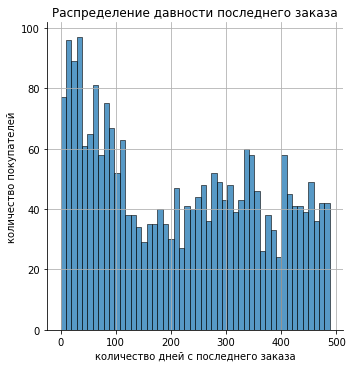

count    2430.000000
mean      215.992593
std       149.143306
min         0.000000
25%        73.000000
50%       210.000000
75%       344.000000
max       488.000000
Name: recency, dtype: float64

In [16]:
# строим график распределения по количеству дней с последнего заказа
sns.displot(RFM_table['recency'], bins=50)
plt.title('Распределение давности последнего заказа')
plt.xlabel('количество дней с последнего заказа')
plt.ylabel('количество покупателей')
plt.grid(True)
plt.show()

# выводим основные статистические характеристики
RFM_table['recency'].describe()

Мы видим, что четверть от всех покупателей последний раз совершали покупку не более 3 месяцев назад, а другая четверть — год назад и более. У половины покупателей последняя покупка была от 3 месяцев до практически года назад.

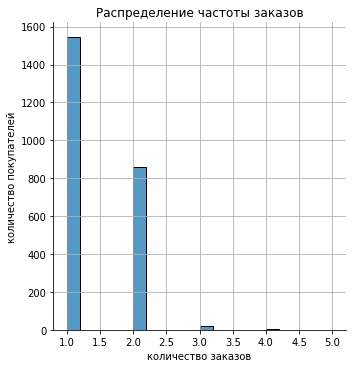

count    2430.000000
mean        1.448971
std         2.688981
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       126.000000
Name: frequency, dtype: float64

In [17]:
# строим график распределения по частоте заказов
sns.displot(RFM_table.query('frequency <= 5')['frequency'], bins=20) # убираем выбросы для наглядности графика
plt.title('Распределение частоты заказов')
plt.xlabel('количество заказов')
plt.ylabel('количество покупателей')
plt.grid(True)
plt.show()

# выводим основные статистические характеристики
RFM_table['frequency'].describe()

Большинство покупателей совершали 1 или 2 заказа.

По максимальному значению мы видим, что есть выбросы. Удалим их из датасета.

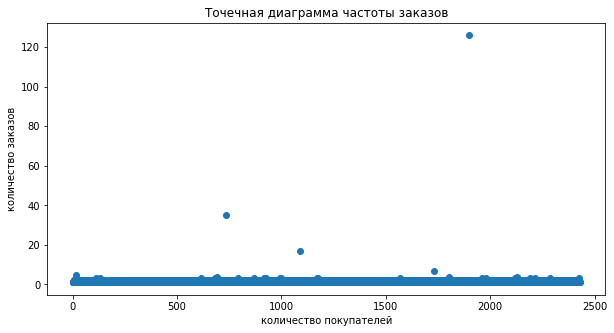

Перцентили 90, 95, 99: [2. 2. 3.]


In [18]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

x_values = pd.Series(range(0,len(RFM_table)))

plt.scatter(x_values, RFM_table['frequency']) 
plt.title('Точечная диаграмма частоты заказов')
plt.xlabel('количество покупателей')
plt.ylabel('количество заказов')
plt.show()

print('Перцентили 90, 95, 99:', np.percentile(RFM_table['frequency'], [90, 95, 99])) 

# объявляем переменную с выбросами для последующего удаления из датасета
abnormal_frequency = RFM_table[RFM_table['frequency'] > np.percentile(RFM_table['frequency'], 95)]['customer_id']

Выбросами будем считать покупателей, совершивших 3 и более заказа.

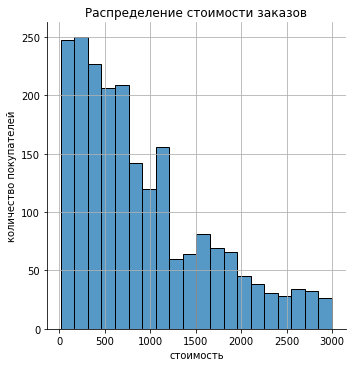

count      2430.000000
mean       1902.017455
std       14329.072490
min          15.000000
25%         391.500000
50%         839.000000
75%        1799.000000
max      675000.000000
Name: monetary_value, dtype: float64

In [19]:
# строим график распределения по стоимости заказов
sns.displot(RFM_table.query('monetary_value <= 3000')['monetary_value'], bins=20) # убираем выбросы для наглядности графика
plt.title('Распределение стоимости заказов')
plt.xlabel('стоимость')
plt.ylabel('количество покупателей')
plt.grid(True)
plt.show()

# выводим основные статистические характеристики
RFM_table['monetary_value'].describe()

Основная масса покупателей совершили покупок на сумму до 1500 рублей, причём больше всего тех, кто потратил до 500 рублей.

Здесь также есть выбросы.

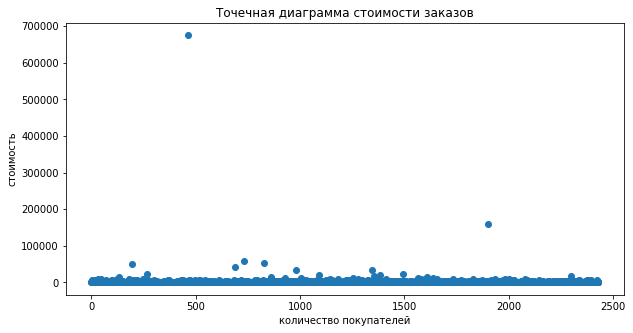

Перцентили 90, 95, 99: [ 3401.2   4902.2  10094.63]


In [20]:
# задаём размер сетки для графиков
plt.figure(figsize=(10, 5))

x_values = pd.Series(range(0,len(RFM_table)))

plt.scatter(x_values, RFM_table['monetary_value']) 
plt.title('Точечная диаграмма стоимости заказов')
plt.xlabel('количество покупателей')
plt.ylabel('стоимость')
plt.show()

print('Перцентили 90, 95, 99:', np.percentile(RFM_table['monetary_value'], [90, 95, 99])) 

# объявляем переменную с выбросами для последующего удаления из датасета
abnormal_monetary_value = RFM_table[RFM_table['monetary_value'] > np.percentile(RFM_table['monetary_value'], 95)]['customer_id']

Покупателей, совершивших заказы на сумму более 4 902 руб. будем считать аномальными и уберём из датасета.

In [21]:
abnormal_customers = (
    pd.concat([abnormal_frequency, abnormal_monetary_value], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_customers.head(5))
print(abnormal_customers.shape[0])
round(len(abnormal_customers)/RFM_table['customer_id'].nunique()*100, 2)

6     005ba170-45e8-42de-93f7-192481ae2659
17    0184f535-b60a-4914-a982-231e3f615206
23    01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33
32    02adb72a-3067-45e9-a3b5-f93d79d7496a
45    04416514-5346-4f90-93e3-fb7365e2ee8c
Name: customer_id, dtype: object
142


5.84

Всего аномальных покупателей 142, это 5,84% от общего числа покупателей.

In [22]:
# удаляем аномальных покупателей из таблицы для RFM анализа и сразу из основного датасета
RFM_table = RFM_table[np.logical_not(RFM_table['customer_id'].isin(abnormal_customers))]
data = data[np.logical_not(data['customer_id'].isin(abnormal_customers))]
RFM_table.shape

(2288, 4)

В таблице для RFM-анализа осталось 2 288 покупателей.

### Промежуточный вывод

По итогам исследовательского анализа:
- Временной период в датасете с 1 октября 2018 года по 31 января 2020 года, количество заказов за этот период составляет 3 521 и количество пользователей 2 288 с учётом удалённых выбросов.
- Подготовили данные для RFM-анализа и посчитали:
    - как давно покупатель совершил покупку?
    - как часто покупатель совершает покупки?
    - сколько покупатель тратит?
- Выяснили, что:
    - Четверть от всех покупателей последний раз совершали покупку не более 3 месяцев назад, а другая четверть — год назад и более. У половины покупателей последняя покупка была от 3 месяцев до практически года назад.
    - Большинство покупателей совершали 1 или 2 заказа.
    - Основная масса покупателей совершили покупок на сумму до 1500 рублей, причём больше всего тех, кто потратил до 500 рублей.

## Сегментация покупателей

Разделим покупателей на 3 сегмента с помощью RFM-анализа.

In [23]:
# используем квантили для разделения данных на 3 части
quantiles = RFM_table.quantile(q=[0.33, 0.66], numeric_only=True)

# конвертируем в словарь для удобства
quantiles = quantiles.to_dict()
segmented_rfm = RFM_table.copy()

# функция для определения класса Recency (x = value, p = recency, monetary_value, frequency, d = quantiles dict)
def R_class(x, p, d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
    
# функция для определения классов Frequency и Monetary Value 
def FM_class(x, p, d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3
    
# создаем дополнительные столбцы с оценками по 3 параметрам
segmented_rfm['R_quantile'] = segmented_rfm['recency'].apply(R_class, args=('recency', quantiles))
segmented_rfm['F_quantile'] = segmented_rfm['frequency'].apply(FM_class, args=('frequency', quantiles))
segmented_rfm['M_quantile'] = segmented_rfm['monetary_value'].apply(FM_class, args=('monetary_value', quantiles))

#объединяем 3 оценки в один столбец
segmented_rfm['RFM_class'] = segmented_rfm.R_quantile.map(str) \
                            + segmented_rfm.F_quantile.map(str) \
                            + segmented_rfm.M_quantile.map(str)

segmented_rfm.head()

,customer_id,recency,frequency,monetary_value,R_quantile,F_quantile,M_quantile,RFM_class
0,000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0,2,1,2,212
1,001cee7f-0b29-4716-b202-0042213ab038,349,1,442.0,1,1,1,111
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,2,1,2,212
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,1,1,3,113
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,2,1,3,213


Мы получили оценки по каждому из параметров, где 3 — лучшая оценка, 1 — худшая оценка. 

Посмотрим, сколько покупателей попадает в каждую группу и сформируем 3 сегмента:
- лояльные;
- спящие;
- потерянные.

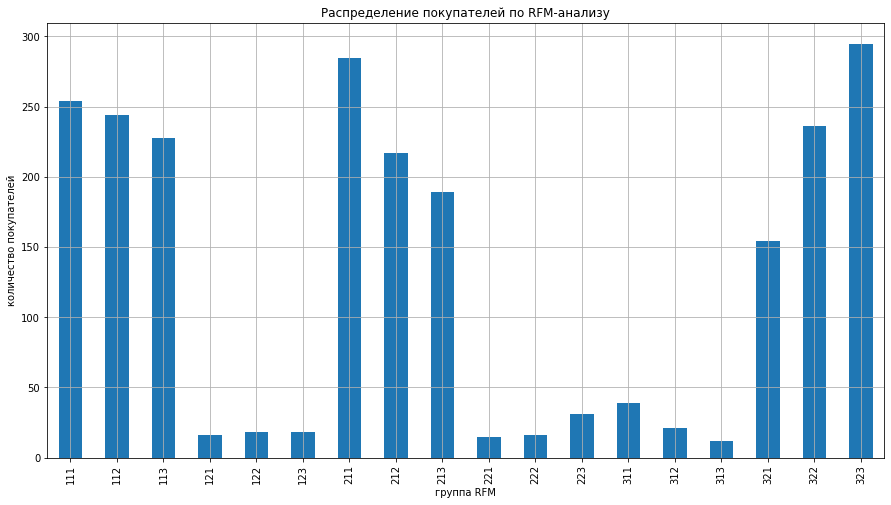

In [24]:
# строим столбчатую диаграмму по RFM группам
fig = plt.figure(figsize=(15, 8))
segmented_rfm.groupby('RFM_class')['customer_id'].agg('nunique').plot(kind='bar')
plt.title('Распределение покупателей по RFM-анализу')
plt.xlabel('группа RFM')
plt.ylabel('количество покупателей')
plt.grid(True)
plt.show()

Получившиеся группы RFM анализа мы можем интерпретировать следующим образом:
- лояльные покупатели:
    - `R=3, F=2, M=3` — покупают недавно, много и в целом нередко;
    - `R=3, F=2, M=2` — покупают недавно, время от времени на среднюю сумму;
    - `R=3, F=2, M=1` — покупают недавно, время от времени на небольшую сумму;
    - `R=3, F=1, M=1/2/3` — недавние новые покупатели.
- спящие покупатели:
    - `R=2, F=1/2/3, M=1/2/3` — спящие покупатели;
    - `R=1, F=2, M=2/3` — бывшие лояльные покупатели.
- потерянные покупатели:
    - `R=1, F=1, M=1` — купили 1 раз, мало и давно;
    - `R=1, F=1, M=2/3` — купили 1 раз на среднюю или большую сумму;
    - `R=1, F=2, M=1` — покупали часто на маленькую сумму.

In [25]:
# объявляем функцию для присвоения сегментов
def segment_choice(row):
    if row['RFM_class'] in ['323', '322', '321', '311', '312', '313']:
        return 'loyal'
    elif row['RFM_class'] in ['211', '212', '213', '221', 
                              '222', '223', '231', '232', 
                              '233', '122', '123']:
        return 'sleeping'
    elif row['RFM_class'] in ['111', '112', '113', '121']:
        return 'lost'
    else:
        return 'not defined'

segmented_rfm['segment'] = segmented_rfm.apply(segment_choice, axis=1)

display(segmented_rfm.head())
segmented_rfm.groupby('segment')['customer_id'].agg('nunique')

,customer_id,recency,frequency,monetary_value,R_quantile,F_quantile,M_quantile,RFM_class,segment
0,000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0,2,1,2,212,sleeping
1,001cee7f-0b29-4716-b202-0042213ab038,349,1,442.0,1,1,1,111,lost
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,2,1,2,212,sleeping
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,1,1,3,113,lost
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,2,1,3,213,sleeping


segment
lost        742
loyal       757
sleeping    789
Name: customer_id, dtype: int64

В итоге у нас 742 потерянных покупателя, 757 лояльных и 789 спящих.

In [26]:
# объявим функцию, которая находит совпадающих пользователей в сегментах
def common_users(grp1, grp2):
    return list(set(segmented_rfm.query('segment == @grp1')['customer_id']).intersection(
        segmented_rfm.query('segment == @grp2')['customer_id']))
    
print('Совпадающие пользователи в сегментах loyal и sleeping:', len(common_users("loyal", "sleeping")))
print('Совпадающие пользователи в сегментах loyal и lost:', len(common_users("loyal", "lost")))
print('Совпадающие пользователи в сегментах lost и sleeping:', len(common_users("lost", "sleeping")))

Совпадающие пользователи в сегментах loyal и sleeping: 0
Совпадающие пользователи в сегментах loyal и lost: 0
Совпадающие пользователи в сегментах lost и sleeping: 0


Совпадающих пользователей в сегментах нет.

### Промежуточный вывод

Мы провели RFM-анализ и разделили покупателей на 3 сегмента:
- ***лояльные покупатели*** — последняя покупка была недавно, покупают регулярно и, как правило, на более крупные суммы;
- ***спящие покупатели*** — те, кто давно ничего не покупал, бывшие лояльные покупатели;
- ***потерянные покупатели*** — последняя покупка была давно, покупали редко и в основном мало.


## Проверка гипотез

Прежде чем анализировать особенности каждого сегмента, проверим корректность разделения с помощью статистического теста.

### Проверка данных на нормальность

Проверим с помощью критерия Шапиро-Уилка, можно ли считать наши 3 параметра нормально распределёнными.

Сформулируем гипотезы:
- **H0** — давность покупки в днях распределена нормально.
- **H1** — давность покупки в днях распределена не нормально.

Уровень статистической значимости выбираем 0,05.

In [27]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(segmented_rfm['recency'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение для давности покупки: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение для давности покупки:  1.8388187600251994e-31
Отвергаем нулевую гипотезу: распределение не нормально


- **H0** — частота покупок распределена нормально.
- **H1** — частота покупок распределена не нормально.

In [28]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(segmented_rfm['frequency'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение для частоты покупок: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение для частоты покупок:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


- **H0** — сумма покупок на покупателя распределена нормально.
- **H1** — сумма покупок на покупателя распределена не нормально.

In [29]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(segmented_rfm['monetary_value'])
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение для суммы покупок: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение для суммы покупок:  1.778247751228193e-42
Отвергаем нулевую гипотезу: распределение не нормально


P-value для всех трёх параметров ниже уровня статистической значимости, переменные распределены не нормально.

### Проверка разделения сегментов

Будем использовать критерий Манна-Уитни, поскольку наши переменные распределены не нормально, а значит, алгебраические метрики будут работать плохо, одно выбивающееся значение может существенно повлиять на результат. Критерий Манна-Уитни основан на структурном подходе и работает с рангами, никак не учитывая сами значения.

Уровень статистической значимости также выбираем 0,05.

Сформулируем гипотезы:

- **H0** — нет различий между сегментами по давности покупки.
- **H1** — есть различия между сегментами по давности покупки.

In [30]:
# создадим отдельные переменные для каждого сегмента
segment_loyal = segmented_rfm.query('segment == "loyal"')
segment_sleeping = segmented_rfm.query('segment == "sleeping"')
segment_lost = segmented_rfm.query('segment == "lost"')

# применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой
print('p-value по давности покупки:')
print('для лояльных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['recency'], segment_sleeping['recency'])[1]))
print('для лояльных и потерянных —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['recency'], segment_lost['recency'])[1]))
print('для потерянных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_lost['recency'], segment_sleeping['recency'])[1]))

p-value по давности покупки:
для лояльных и спящих — 0.000
для лояльных и потерянных — 0.000
для потерянных и спящих — 0.000


Сделаем поправку на множественную проверку с помощью метода Холма.

In [31]:
rec_pvalue_ls = st.mannwhitneyu(segment_loyal['recency'], segment_sleeping['recency'])[1]
rec_pvalue_ll = st.mannwhitneyu(segment_loyal['recency'], segment_lost['recency'])[1]
rec_pvalue_sl = st.mannwhitneyu(segment_lost['recency'], segment_sleeping['recency'])[1]
rec_pvalue = [rec_pvalue_ls, rec_pvalue_ll, rec_pvalue_sl]
rec_reject, rec_p_corrected, a1, a2 = multipletests(rec_pvalue, alpha = 0.05, method = 'holm')
print(rec_reject)
print(rec_p_corrected)

[ True  True  True]
[2.12882272e-253 5.36226757e-246 1.58595446e-232]


По давности покупки p-value ниже 0,05, поэтому мы отвергаем нулевую гипотезу, различия между сегментами есть. 

- **H0** — нет различий между сегментами по частоте покупок.
- **H1** — есть различия между сегментами по частоте покупок.

In [32]:
print('p-value по частоте покупок:')
print('для лояльных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['frequency'], segment_sleeping['frequency'])[1]))
print('для лояльных и потерянных —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['frequency'], segment_lost['frequency'])[1]))
print('для потерянных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_lost['frequency'], segment_sleeping['frequency'])[1]))

p-value по частоте покупок:
для лояльных и спящих — 0.000
для лояльных и потерянных — 0.000
для потерянных и спящих — 0.000


In [33]:
freq_pvalue_ls = st.mannwhitneyu(segment_loyal['frequency'], segment_sleeping['frequency'])[1]
freq_pvalue_ll = st.mannwhitneyu(segment_loyal['frequency'], segment_lost['frequency'])[1]
freq_pvalue_sl = st.mannwhitneyu(segment_lost['frequency'], segment_sleeping['frequency'])[1]
freq_pvalue = [freq_pvalue_ls, freq_pvalue_ll, freq_pvalue_sl]
freq_reject, freq_p_corrected, a1, a2 = multipletests(freq_pvalue, alpha = 0.05, method = 'holm')
print(freq_reject)
print(freq_p_corrected)

[ True  True  True]
[1.99663335e-206 9.87390679e-257 2.11827116e-014]


По частоте покупок точно такая же ситуация, различия есть между всеми тремя сегментами.

- **H0** — нет различий между сегментами по сумме покупки.
- **H1** — есть различия между сегментами по сумме покупки.

In [34]:
print('p-value по сумме покупки:')
print('для лояльных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['monetary_value'], segment_sleeping['monetary_value'])[1]))
print('для лояльных и потерянных —', "{0:.3f}".format(st.mannwhitneyu(segment_loyal['monetary_value'], segment_lost['monetary_value'])[1]))
print('для потерянных и спящих —', "{0:.3f}".format(st.mannwhitneyu(segment_lost['monetary_value'], segment_sleeping['monetary_value'])[1]))

p-value по сумме покупки:
для лояльных и спящих — 0.000
для лояльных и потерянных — 0.000
для потерянных и спящих — 0.364


In [35]:
mon_pvalue_ls = st.mannwhitneyu(segment_loyal['monetary_value'], segment_sleeping['monetary_value'])[1]
mon_pvalue_ll = st.mannwhitneyu(segment_loyal['monetary_value'], segment_lost['monetary_value'])[1]
mon_pvalue_sl = st.mannwhitneyu(segment_lost['monetary_value'], segment_sleeping['monetary_value'])[1]
mon_pvalue = [mon_pvalue_ls, mon_pvalue_ll, mon_pvalue_sl]
mon_reject, mon_p_corrected, a1, a2 = multipletests(mon_pvalue, alpha = 0.05, method = 'holm')
print(mon_reject)
print(mon_p_corrected)

[ True  True False]
[3.15004307e-09 1.83146450e-07 3.64413401e-01]


По сумме покупки между лояльными и спящими/потерянными есть различия, p-value ниже уровня статистической значимости, а между потерянными и спящими p-value значительно больше 0,05, поэтому мы не можем отвергнуть нулевую гипотезу.

### Промежуточный вывод

- с помощью критерия Шапиро-Уилка мы проверили наши переменные на нормальность распределения;
- выбрали критерий Манна-Уитни, поскольку распределения не нормальны;
- сделали поправку на множественную проверку с помощью метода Холма;
- можно считать, что наши 3 сегмента выделены корректно, различия есть между всеми сегментами по давности и частоте покупок, а по сумме покупок нет значимых различий только между потерянными и спящими.

## Особенности сегментов

Теперь мы можем перейти к анализу особенностей каждого сегмента. Для этого добавим в основной датасет столбец с сегментами.

In [36]:
# объявляем функцию для создания столбца с сегментами в основном датасете
def segment_to_data(row):
    if row['customer_id'] in segment_loyal['customer_id'].tolist():
        return 'loyal'
    elif row['customer_id'] in segment_sleeping['customer_id'].tolist():
        return 'sleeping'
    elif row['customer_id'] in segment_lost['customer_id'].tolist():
        return 'lost'

data['segment'] = data.apply(segment_to_data, axis=1)
data.head()

,date,customer_id,order_id,product,quantity,price,customers_quantity,total,segment
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,1,142.0,lost
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,1,194.0,lost
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,1,112.0,lost
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,1,179.0,lost
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,1,112.0,lost


### Топ категорий товаров

Рассмотрим топ категорий товаров в каждом сегменте. Добавим еще один столбец с разделением товаров на категории.

,date,customer_id,order_id,product,quantity,price,customers_quantity,total,segment,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,1,142.0,lost,Растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,1,194.0,lost,Растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,1,112.0,lost,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,1,179.0,lost,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,1,112.0,lost,Растения


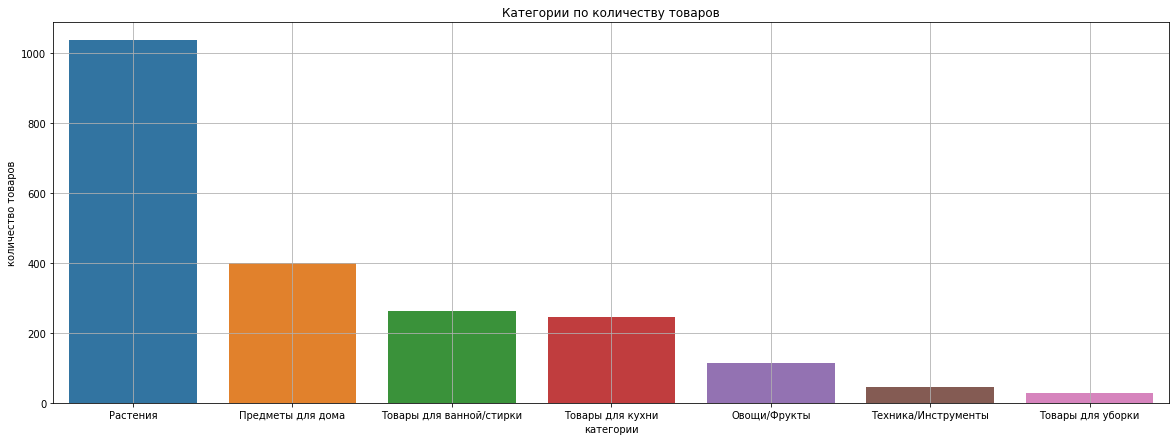

In [37]:
# создаем словарь для разделения товаров на категории
product_categories = {
    'Растения': ['растение', 'рассада', 'розмарин', 'роза', 'рудбекия', 'пуансеттия', 
                 'пеларгония', 'радермахера', 'хризолидокарпус', 'циперус', 'сантолина', 'd-',
                'аквилегия', 'примула', 'кашпо', 'алиссум', 'петуния', 'пиретрум', 'анемона',
                'седум', 'ранункулус', 'овсянница', 'солидаго', 'антуриум', 'смолевка',
                'астра', 'петля', 'папоротник', 'настурция', 'гвоздика', 'вербена', 'дерево', 'ромашка',
                'незабудка', 'бадан', 'декабрист', 'бархатцы', 'фуксия', 'флокс', 'колокольчик', 'лобелия', 
                'калибрахоа', 'осина', 'кореопсис', 'физостегия', 'лавр', 'цинния', 'монарда', 'гиностемма',
                'энотера', 'цикламен,', 'георгина', 'кипарисовик', 'бузульник', 'любисток', 'цинерария', 'эшшольция',
                'камнеломка', 'вербейник', 'барвинок', 'маттиола', 'космея', 'виола', 'хризантема', 'лилейник', 'тюльпан',
                'эхинацея', 'цикламен', 'ель', 'бегония', 'платикодон', 'котовник', 'змееголовник', 'гайлардия', 'годеция',
                'клен', 'лаватера', 'лапчатка', 'лен', 'валериана', 'ясколка', 'вероника', 'хоста', 'кодонанта',
                'дендробиум', 'гипсофила', 'вигна', 'виноград', 'калла'],
    'Товары для ванной/стирки': ['доска', 'таз', 'сушилка', 'гладильн', 'ёрш', 'ерш', 'пробка', 'ванн', 
                                 'подрукавник', 'прищепки', 'прищепок', 'сетка', 'вантуз', 'бак', 'стирк', 'бидон',
                                'зубная паста', 'мыл', 'увлажняющ'],
    'Товары для кухни': ['чайник', 'тарелка', 'вилка', 'ложка', 'кружка', 'кружек', 'салфетк', 'салфеток', 'салатник',
                        'салфетница', 'рыбочистка', 'противень', 'просеиватель', 'рассекатель', 'нож',
                        'скатерть', 'половник', 'пресс', 'зажигалка', 'сахарница', 'сито',
                        'банка', 'стакан', 'сковород', 'сотейник', 'скалка', 'термос', 'чайн', 'овощечистка',
                        'кувшин', 'бульонница', 'кастрюл', 'фужер', 'хлебница', 'тортница', 'блюд', 'миска', 'ваза', 
                        'ковш', 'форм', 'венчик', 'лопатка', 'терка', 'тёрка', 'картофелемялка', 'орехоколка', 'столов',
                        'бокал', 'масленк', 'посуд', 'котел', 'толкушка', 'емкость'],
    'Овощи/Фрукты': ['томат', 'огурец', 'морковь', 'салат', 'капуста', 'базилик', 'клубника', 
                     'земляника', 'укроп', 'тимьян', 'сельдерей', 'арбуз', 'петрушка', 'шалфей', 'лук', 'горох',
                    'дыня', 'кориандр'],
    'Предметы для дома': ['вешалк', 'вешалок', 'ролик', 'простын', 'мебель', 'покрывало', 'решетка', 'полка', 
                        'полки', 'одеял', 'подкладка', 'полотенце', 'полотенец', 'подушка', 'плечики', 'плед', 'подставка',
                       'коврик', 'ковёр', 'ковер', 'муляж', 'искусственн', 'декор', 'стеллаж', 'стремянк', 'скребок', 'насадка', 
                        'совок', 'щетка', 'перчатки', 'подголовник', 'пуф', 'коробка', 'уголок', 'сметка', 
                        'чехол', 'корзина', 'ключница', 'весы', 'кофр', 'ящик', 'матрас', 'матрац', 'наволочка', 'обув',
                       'комод', 'урна', 'карниз', 'контейнер', 'халат', 'лоток', 'корзинка', 'ткан', 'пакет',
                       'рамка', 'сумка', 'тележка'],
    'Техника/Инструменты': ['пылесос', 'сверло', 'светильник', 'утюг', 'миксер', 'термометр', 'фен', 'электроштопор', 
                'овощеварка',  'мантоварка', 'штангенциркуль', 'соковарка', 'инструмент', 'соковыжималка', 'кипятильник', 
                'сверел', 'крепеж', 'скоба', 'линейка', 'напильник', 'электр', 'шнур', 'крючок', 'кисточка', 'кольца',
                           'стяжка', 'шпингалет', 'бензин','сварка', 'фиксатор', 'завертка', 'шило', 'фал'],
    'Товары для уборки': ['средство', 'антижир', 'паста', 'швабра', 'окномойка', 'губк', 'тряпк', 'ведр',
                                'веник', 'мытья', 'отбеливатель', 'ополаскиватель', 'чистящий']
}

# объявляем функцию для добавления столбца с категориями в датасет
def categorize(row):
    value = row['product'].lower()
    for k in product_categories.keys():
        for v in range(len(product_categories[k])):
            if product_categories[k][v] in value:
                return k
            else:
                continue
   
    
data['category'] = data.apply(categorize, axis=1)
display(data.head())

# строим график по количеству товаров в категориях
plt.figure(figsize=(20, 7))
ax = sns.barplot(x='category', y='product', data=data.groupby(
    'category', as_index=False)['product'].agg('nunique').sort_values(by='product', ascending=False))
ax.set(title='Категории по количеству товаров', xlabel='категории', ylabel='количество товаров')
plt.grid(True)
plt.show()

Больше всего товаров в категории `Растения`, далее идут `Предметы для дома`, `Товары для ванной/стирки` и `Товары для кухни`.

Посмотрим, есть ли различия в топе категорий между сегментами.

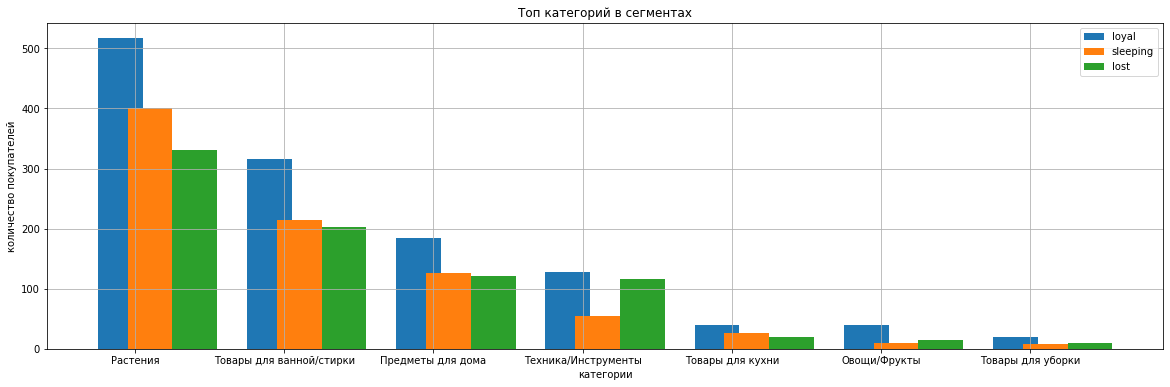

In [38]:
# объявляем переменную для подписей оси x
cat_par = data['category'].unique()
x = np.arange(len(cat_par))

# подготавливаем сводные таблицы по каждому сегменту
table1 = data.query('segment == "loyal"').pivot_table(index='category', values='customer_id', aggfunc='nunique').sort_values(by='customer_id', ascending=False)
table2 = data.query('segment == "sleeping"').pivot_table(index='category', values='customer_id', aggfunc='nunique').sort_values(by='customer_id', ascending=False)
table3 = data.query('segment == "lost"').pivot_table(index='category', values='customer_id', aggfunc='nunique').sort_values(by='customer_id', ascending=False)

g1 = table1['customer_id']
g2 = table2['customer_id']
g3 = table3['customer_id']

width = 0.3

# строим столбчатую диаграмму по категориям во всех 3 сегментах
fig, ax = plt.subplots(figsize=(20, 6))
rects1 = ax.bar(x - width/3, g1, width, label='loyal')
rects2 = ax.bar(x + width/3, g2, width, label='sleeping')
rects3 = ax.bar(x + 4*width/3, g3, width, label='lost')
ax.set(title='Топ категорий в сегментах', xlabel='категории', ylabel='количество покупателей')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend()
plt.grid(True)
plt.show()

Во всех трёх сегментах самая популярная категория товаров — это растения, далее идут товары для ванной и стирки, и замыкают топ-3 предметы для дома.

### Сезонность категорий

Посмотрим, как различается сезонность категорий для каждого сегмента.

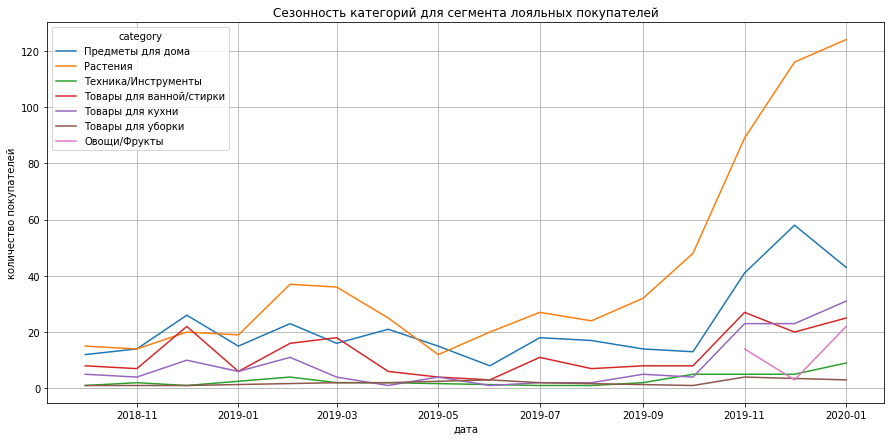

In [39]:
# вычленяем из даты месяц и год для графика
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['month_year'] = data.month.map(str)+data.year.map(str)
data['month_year'] = pd.to_datetime(data['month_year'], format="%m%Y")

# группируем данные по дате и категориям
seasons_loyal = data.query('segment=="loyal"').groupby(
    ['month_year', 'category'], as_index=False)['order_id'].agg('nunique')
seasons_sleeping = data.query('segment=="sleeping"').groupby(
    ['month_year', 'category'], as_index=False)['order_id'].agg('nunique')
seasons_lost = data.query('segment=="lost"').groupby(
    ['month_year', 'category'], as_index=False)['order_id'].agg('nunique')

# строим график по месяцам для сегмента loyal
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x='month_year', y='order_id', hue='category', data=seasons_loyal)
ax.set(title='Сезонность категорий для сегмента лояльных покупателей', xlabel='дата', ylabel='количество покупателей')
plt.grid(True)
plt.show()

В сегменте лояльных покупателей количество заказов под конец увеличилось за счёт покупателей, которые начали совершать покупки недавно. 
- Спрос на овощи и фрукты начинает расти с ноября до января. 
- Пик товаров для кухни приходится на декабрь-февраль. 
- Товары для ванной и стирки в целом пользуются более высоким спросом в зимние месяцы, а в летние меньшим. 
- Предметы для дома держатся более-менее на одном уровне. 
- Спрос на растения больше всего с февраля по апрель, а также с июля по сентябрь.

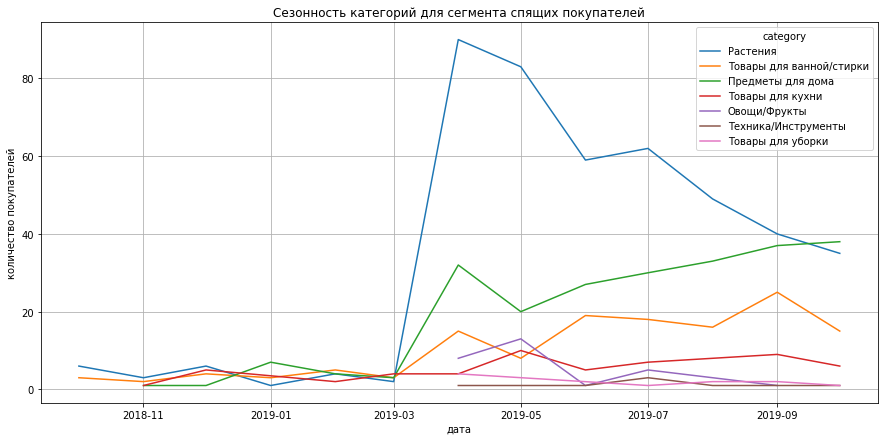

In [40]:
# строим график по месяцам для сегмента sleeping
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x='month_year', y='order_id', hue='category', data=seasons_sleeping)
ax.set(title='Сезонность категорий для сегмента спящих покупателей', xlabel='дата', ylabel='количество покупателей')
plt.grid(True)
plt.show()

Для сегмента спящих покупателей:
- Пик спроса на овощи и фрукты приходится на май.
- Товары для ванной и стирки пользуются спросом более-менее одинаково на протяжении всего периода.
- У предметов для дома пик — в апреле.
- Растения покупают чаще в апреле-мае и в июле.
- Также есть пик в декабре у предметов для дома и кухни, когда все покупают подарки.

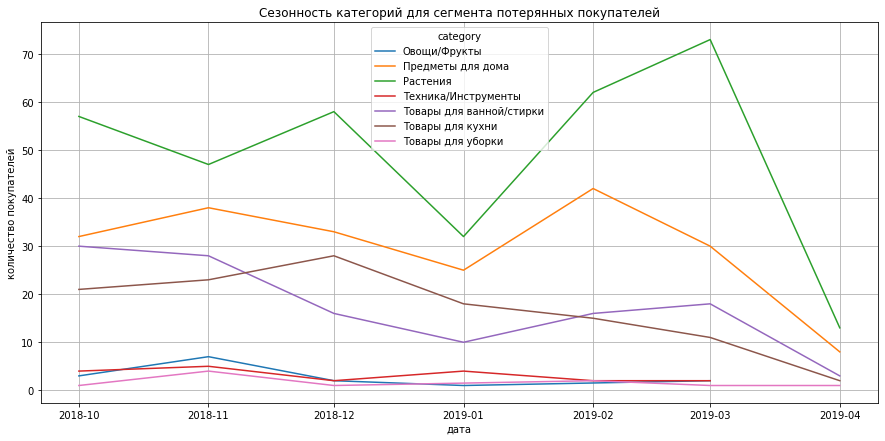

In [41]:
# строим график по месяцам для сегмента lost
plt.figure(figsize=(15, 7))
ax = sns.lineplot(x='month_year', y='order_id', hue='category', data=seasons_lost)
ax.set(title='Сезонность категорий для сегмента потерянных покупателей', xlabel='дата', ylabel='количество покупателей')
plt.grid(True)
plt.show()

Для сегмента потерянных покупателей:
- Пик спроса на растения в декабре и марте.
- На предметы для дома спрос более-менее на одном уровне.
- Товары для кухни чаще покупали в декабре, и дальше спрос шёл на спад.
- Товары для ванной и стирки пользовались более высоким спросом в ноябре и марте.

### Средний чек по сегментам

Исследуем, насколько сильно отличается средний чек между сегментами.

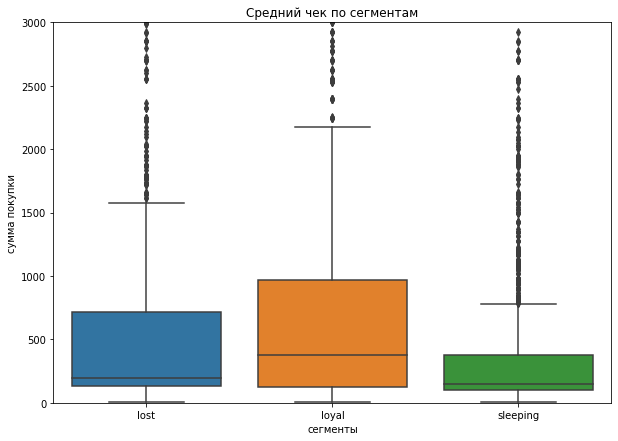

Лояльные покупатели
count    1443.000000
mean      692.740067
std       848.104744
min         9.000000
25%       128.000000
50%       374.000000
75%       966.500000
max      4499.000000
Name: total, dtype: float64

Спящие покупатели
count    2071.000000
mean      398.622405
std       649.706172
min         9.000000
25%       102.500000
50%       149.000000
75%       374.000000
max      4874.000000
Name: total, dtype: float64

Потерянные покупатели
count    1387.000000
mean      553.535689
std       766.947857
min         9.000000
25%       132.000000
50%       194.000000
75%       712.000000
max      4900.000000
Name: total, dtype: float64


In [42]:
# строим диаграмму размаха для каждого сегмента
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=data, y='total', x='segment')
ax.set(title='Средний чек по сегментам', xlabel='сегменты', ylabel='сумма покупки')
plt.ylim(0, 3000)
plt.show()

# выводим основные статистические характеристики
print('Лояльные покупатели')
print(data.query('segment=="loyal"')['total'].describe())
print()
print('Спящие покупатели')
print(data.query('segment=="sleeping"')['total'].describe())
print()
print('Потерянные покупатели')
print(data.query('segment=="lost"')['total'].describe())

Выше всего средний чек у лояльных покупателей — 374 руб., а также шире разброс. У спящих и потерянных клиентов средний чек примерно на одном уровне, у спящих — 149 руб, у потерянных — 194 руб. При этом разброс шире у потерянных клиентов.

Посмотрим на средний чек по категориям в каждом сегменте.

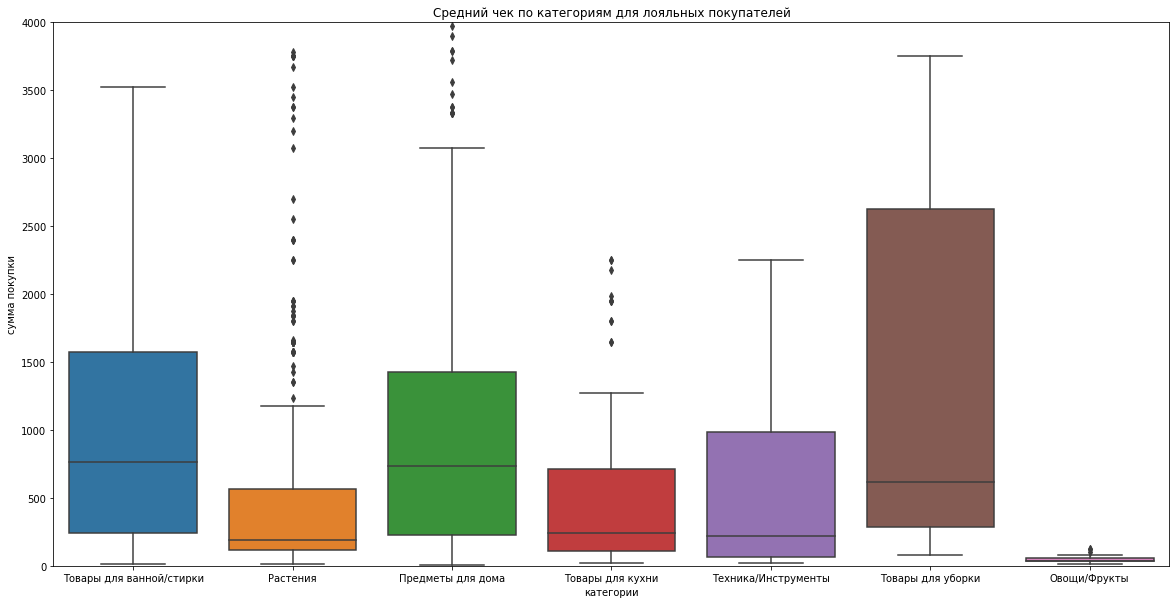

In [43]:
# строим диаграмму размаха по категориям для лояльных покупателей
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=data.query('segment=="loyal"'), y='total', x='category')
ax.set(title='Средний чек по категориям для лояльных покупателей', xlabel='категории', ylabel='сумма покупки')
plt.ylim(0, 4000)
plt.show()

Для сегмента лояльных покупателей выше всего средний чек у товаров для ванной и стирки, предметов для дома и товаров для уборки — около 800 руб. Средний чек на растения, товары для кухни и технику около 250 руб.

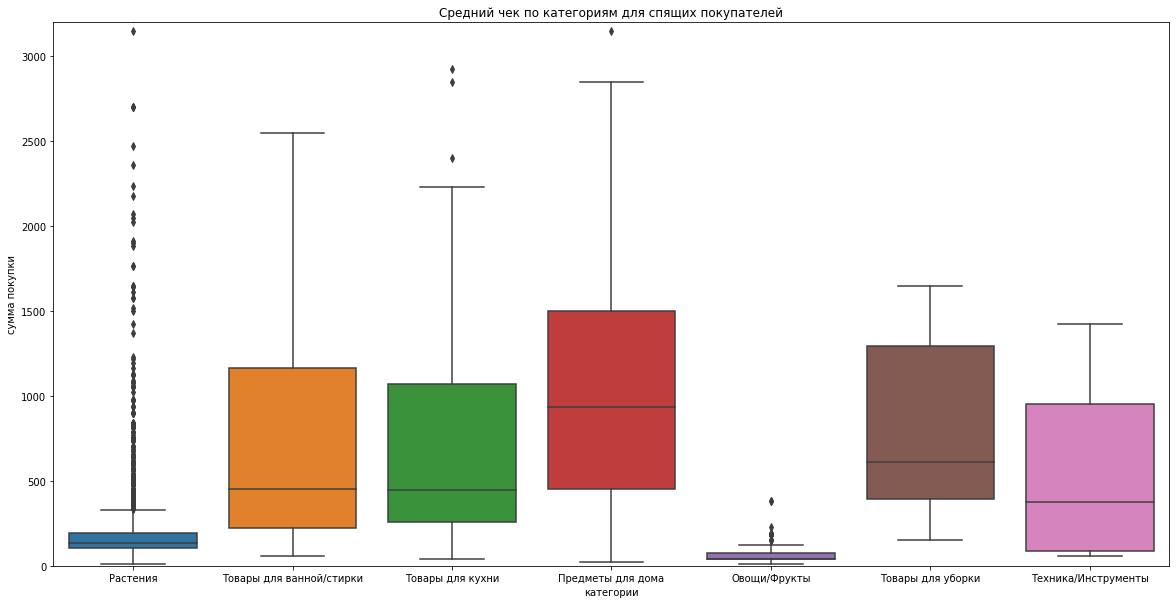

In [44]:
# строим диаграмму размаха по категориям для спящих покупателей
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=data.query('segment=="sleeping"'), y='total', x='category')
ax.set(title='Средний чек по категориям для спящих покупателей', xlabel='категории', ylabel='сумма покупки')
plt.ylim(0, 3200)
plt.show()

Для сегмента спящих покупателей выше всего средний чек на предметы для дома — около 1000 руб, далее идут товары для уборки — около 700 руб., товары для ванной/стирки и для кухни — около 500 руб.

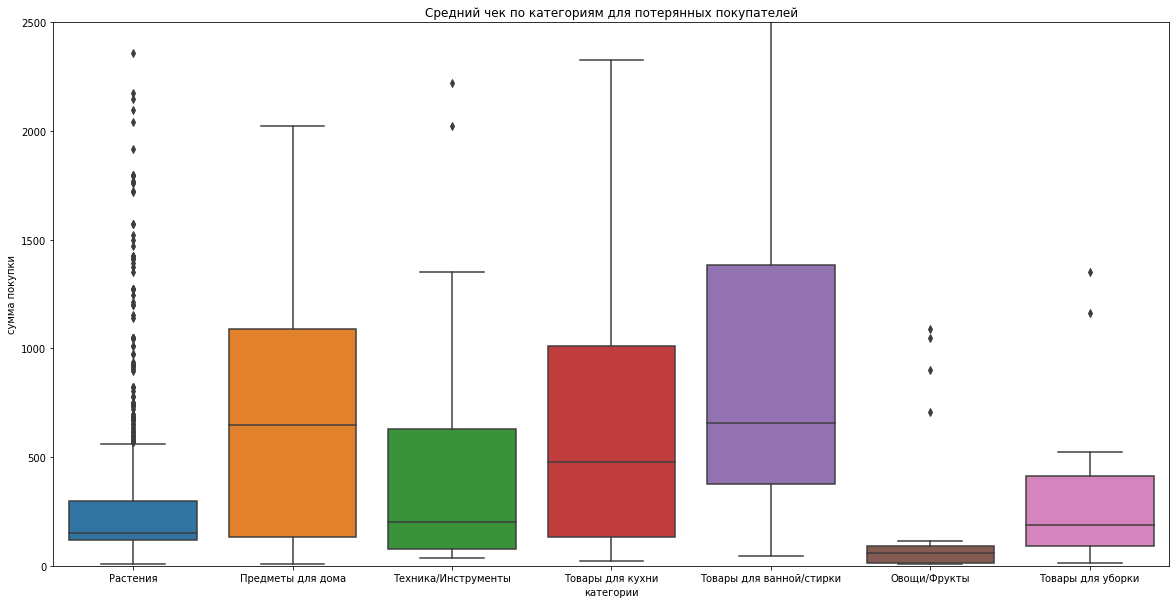

In [45]:
# строим диаграмму размаха по категориям для потерянных покупателей
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=data.query('segment=="lost"'), y='total', x='category')
ax.set(title='Средний чек по категориям для потерянных покупателей', xlabel='категории', ylabel='сумма покупки')
plt.ylim(0, 2500)
plt.show()

Для сегмента потерянных покупателей выше всего средний чек на товары для ванной и стирки и предметы для дома — около 600 руб., далее на товары для кухни — около 500 руб.

### Промежуточный вывод

Во всех трёх сегментах самая ***популярная категория*** товаров — это растения, далее идут товары для ванной и стирки, и замыкают топ-3 предметы для дома. 

Общие тенденции по ***сезонности*** для всех сегментов:
- `Растения` чаще покупают в феврале-апреле и в августе-октябре;
- `Овощи/Фрукты` пользуются более высоким спросом с ноября по январь;
- Остальные категории имеют более-менее равномерный спрос;
- В целом у категорий `Растения`, `Предметы для дома`, `Товары для кухни` и `Товары для ванной и стирки` есть пик спроса в декабре — в предпраздничный период.

Выше всего **средний чек** у лояльных покупателей — 374 руб., а также шире разброс. У спящих и потерянных клиентов средний чек примерно на одном уровне, у спящих — 149 руб, у потерянных — 194 руб. При этом разброс шире у потерянных клиентов.
- Для сегмента лояльных покупателей выше всего средний чек у товаров для ванной и стирки, предметов для дома и товаров для уборки — около 800 руб. Средний чек на растения, товары для кухни и технику около 250 руб.
- Для сегмента спящих покупателей выше всего средний чек на предметы для дома — около 1000 руб, далее идут товары для уборки — около 700 руб., товары для ванной/стирки и для кухни — около 500 руб.
- Для сегмента потерянных покупателей выше всего средний чек на товары для ванной и стирки и предметы для дома — около 600 руб., далее на товары для кухни — около 500 руб.

## Общий вывод

В нашем распоряжении был датасет на 7474 строки с данными о транзакциях покупателей с наименованиями товаров, количеством и ценой.

Мы провели **предобработку данных**:
- скорректировали типы данных в столбце `date` с int на datetime и в столбце `order_id` с int на object;
- удалили 1864 неявных дубликатов.

По итогам **исследовательского анализа**:
- Временной период в датасете с 1 октября 2018 года по 31 января 2020 года, количество заказов за этот период составляет 3 521 и количество пользователей 2 288.
- Подготовили данные для RFM-анализа;
- Выяснили, что:
    - Четверть от всех покупателей последний раз совершали покупку не более 3 месяцев назад, а другая четверть — год назад и более. У половины покупателей последняя покупка была от 3 месяцев до практически года назад.
    - Большинство покупателей совершали 1 или 2 заказа.
    - Основная масса покупателей совершили покупок на сумму до 1500 рублей, причём больше всего тех, кто потратил до 500 рублей.
    
Мы провели **RFM-анализ** и разделили покупателей на 3 сегмента:
- лояльные покупатели;
- спящие покупатели;
- потерянные покупатели.

**Проверили гипотезы** с помощью статистического теста:
- с помощью критерия Шапиро-Уилка мы проверили наши переменные на нормальность распределения;
- выбрали критерий Манна-Уитни, поскольку распределения не нормальны;
- сделали поправку на множественную проверку с помощью метода Холма;
- можно считать, что наши 3 сегмента выделены корректно, различия есть между всеми сегментами по давности и частоте покупок, а по сумме покупок нет значимых различий только между потерянными и спящими.

**Рекомендации по каждому сегменту**:
1. ***лояльные покупатели*** — последняя покупка была недавно, покупают регулярно и относительно много;
    - ***средний чек*** — 374 руб., выше всего на `товары для ванной и стирки`, `предметы для дома` и `товары для уборки` — около 800 руб., на `растения`, `товары для кухни` и `технику` — около 250 руб.
    - ***сезонность*** — спрос на `овощи и фрукты` начинает расти с ноября до января, пик `товаров для кухни` приходится на декабрь-февраль, `товары для ванной и стирки` в целом пользуются более высоким спросом в зимние месяцы, а в летние меньшим. Спрос на `растения` больше всего с февраля по апрель, а также с июля по сентябрь.
    - ***популярные категории*** — `растения`, `товары для ванной/стирки`, `предметы для дома`, `техника/инструменты`.
    - ***стратегия*** — можно предлагать более дорогой товар особенно в категориях «Товары для ванной и стирки», «Предметы для дома» и «Товары для уборки». Категорию «Растения» предлагать с февраля по апрель и с июля по сентябрь. В декабре предлагать категории «Предметы для дома» и «Товары для кухни», так как спрос на подарки перед новым годом растёт именно на эти категории.


2. ***спящие покупатели*** — те, кто давно ничего не покупал, бывшие лояльные покупатели;
    - ***средний чек*** — 149 руб., выше всего на `предметы для дома` — около 1000 руб, далее идут `товары для уборки` — около 700 руб., `товары для ванной/стирки` и `товары для кухни` — около 500 руб.
    - ***сезонность*** — пик спроса на `овощи и фрукты` приходится на май, `товары для ванной и стирки` пользуются спросом более-менее одинаково на протяжении всего периода, у `предметов для дома` пик — в апреле, `растения` покупают чаще в апреле-мае и в июле, также есть пик в декабре у `предметов для дома` и `товаров для кухни`, когда все покупают подарки.
    - ***популярные категории*** — `растения`, `товары для ванной/стирки`, `предметы для дома`.
    - ***стратегия*** — для этого сегмента можно попытаться увеличить количество продаваемого товара и возвращаемость покупателей. Предлагать более дешёвый товар, а также делать рассылки о распродажах и выгодных предложениях. Акцент делать на категориях «Растения» (с февраля по апрель и с июля по сентябрь), «Предметы для дома» и «Товары для ванной и стирки». Также делать рассылки в декабре на «Предметы для дома» и «Товары для кухни».


3. ***потерянные покупатели*** — последняя покупка была давно, покупали редко и в основном мало.
    - ***средний чек*** — 194 руб., выше всего на `товары для ванной и стирки` и `предметы для дома` — около 600 руб., далее на `товары для кухни` — около 500 руб.
    - ***сезонность*** — пик спроса на `растения` в декабре и марте, на `предметы для дома` спрос более-менее на одном уровне, `товары для кухни` чаще покупали в декабре, и дальше спрос шёл на спад, `товары для ванной и стирки` пользовались более высоким спросом в ноябре и марте.
    - ***популярные категории*** — `растения`, `товары для ванной/стирки`, `предметы для дома`, `техника/инструменты`.
    - ***стратегия*** — на этот сегмент нет особого смысла тратить бюджет, при желании можно попробовать вернуть покупателей с помощью спецпредложения или крупной скидки.
